状態が常に同じで報酬が変化しない場合（状態が1つしかない）場合は，Qテーブルを使わなくてもいける

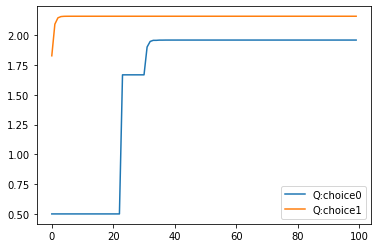

In [6]:
import numpy as np
import random
import math

# 現在のQ値を保持する．状態は常に同じ選択肢は常に同じものが2
Q = np.zeros((2), dtype=np.float)

# グラフの描画のために過去のQ値の変遷を100試行分格納する配列
Qpast = np.zeros((100, 2), dtype=np.float)

#Qの初期値．両方とも半々に設定する
Q[0] = 0.5
Q[1] = 0.5

Qpast[0][0] = Q[0]
Qpast[0][1] = Q[1]

# 報酬は，選択肢0の時は常に1.0, 選択肢1の時は常に1.2
rewards = np.array([1.0, 1.2], dtype=np.float)

# 学習率アルファ
learning_rate = 0.8

# 減衰割引率ガンマ
decay_discount_factor = 0.8

for t in range(0, 100, 1):
  # 現在の試行回数がtに入る
  # ルーレット方式で選択肢を決定する　（一般的にはε-グリーディ法を使うので，ちょっと違うが，わかりやすくするため）
  # 現在のQ値のルーレットを作成
  sumQ = np.sum(Q)
  roulette_number = random.random() * sumQ
  if roulette_number < Q[0]:
    # 選択肢0が選ばれた
    current_rewards = rewards[0]
    # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
    nextQ0 = Q[0] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[0])
    # 選択肢0のQ値を更新
    Qpast[t][0] = Q[0] = nextQ0
    # 選択肢1のQ値は変わらない
    Qpast[t][1] = Q[1]

  else:
    # 選択肢1が選ばれた
    current_rewards = rewards[1]
    # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
    nextQ1 = Q[1] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[1])
    # 選択肢1のQ値を更新
    Qpast[t][1] = Q[1] = nextQ1
    # 選択肢0のQ値は変わらない
    Qpast[t][0] = Q[0]

import matplotlib.pyplot as plt
x_array = np.array([range(0, 100, 1)]).ravel()
# 描画のために選択肢0と1の系列を引っ張り出すため，transposeで次元をひっくり返す
Qpast = Qpast.transpose()
plt.plot(x_array, Qpast[0].ravel(), label='Q:choice0')
plt.plot(x_array, Qpast[1].ravel(), label='Q:choice1')
plt.legend()
plt.show()
# あっという間に収束する

状態が複数あり，かつ報酬が状態によって変わるので，Q-tableを使う場合

[[1.44508273 1.2952722  1.0136451 ]
 [1.38058618 1.45126534 1.38228299]
 [1.17511128 1.16889126 1.34100931]
 [1.34546736 1.48883094 1.21991402]]
[[0.1        2.4863293  0.1       ]
 [2.44874291 2.44603104 2.45517088]
 [2.33290839 2.32455568 2.50013254]
 [2.53629082 2.56561049 0.1       ]]


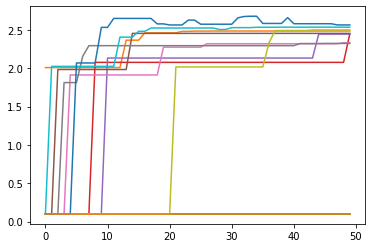

In [14]:
import numpy as np
import random

num_of_state = 4 #状態数
num_of_choice = 3 #選択肢数
num_of_trials = 50 # 試行回数

# 現在のQ値を保持するQ-table．状態数4，選択肢数3(0~3), 初期値を0.1で入れておく
# 最初の選択をするために，最初のQ値が必要となるから
Q = np.full((num_of_state, num_of_choice), 0.1, dtype=np.float)

# グラフの描画のために過去のQ値の変遷を100試行分格納する配列
# 状態数*選択肢数分保持する
Qpast = np.zeros((num_of_trials, num_of_state, num_of_choice), dtype=np.float)

# この計算では，報酬は，状態数*選択肢数の配列で，固定しておく
# つまり，選択した行動の報酬は現在の状態によって変わるが，探索中に動いたりはしない
# 1~1.5のランダムな値を入れておく
rewards = np.zeros((num_of_state, num_of_choice), dtype=np.float)
for i in range(num_of_state):
  for j in range(num_of_choice):
    rewards[i][j] = random.random() * 0.5 + 1.0
print(rewards)

# 学習率アルファ
learning_rate = 0.8

# 減衰割引率ガンマ
decay_discount_factor = 0.8

# 初期状態は，状態0とする
current_status = 0
# 100試行分の状態を記録する配列を作っておく
status_past = np.zeros((num_of_trials), dtype=np.int)
status_past[0] = current_status

# ε-グリーディの，通常選択のアルゴリズム， Roulette or Softmax
choice_algorithm = 'Softmax'
# Softmaxの逆温度 1.0以上の値が入る．逆温度が大きいとSoftmaxがスレッショルドに近くなる
inverse_temperature = 1.0

# 状態遷移テーブルを作る
# この状態の時，この選択肢が選択されたら，次の状態が決まるというやつ
# これは確率にしても良いし，現在の状態とか状態の蓄積から決定木を書いても良い
# とりあえず確率にしておく
# 確率なので，1つの状態から1つの選択肢で移動する状態の確率は1.0である必要がある．
# 状態は再帰の場合もあることとする
status_transition_ratio = np.zeros((num_of_state, num_of_choice, num_of_state), dtype=np.float)

# 一つの状態で一つの選択肢からの状態遷移の総和が1.0になるように，ランダムに値を入れる
for i in range(num_of_state):
  for j in range(num_of_choice):
    s_array = np.zeros((num_of_state), dtype=np.float)
    for k in range(num_of_state):
      s_array[k] = random.random()
    for k in range(num_of_state):
      status_transition_ratio[i][j][k] = 1.0 / np.sum(s_array) * s_array[k]

# 状態遷移確率テーブルの出力
#for i in range(num_of_state):
#  print(status_transition_ratio[i])

# 終端状態が存在する場合は，初期状態に戻ることを確率として書いておけば良い

for t in range(0, num_of_trials, 1):
  # 現在の試行回数がtに入る

  # ε-グリーディ法で行動を選択する

  # ある適当な定数を用意（ε = 0.3）
  # 行動選択の際、0~1の間の乱数を生成し、その値がε以下であればランダムに行動を選択する
  # εより大きければQ値の大きい行動を選択する(ルーレット選択かSoftmax)
  epsilon = 0.3
  if random.random() < epsilon:
    current_choice = random.randint(0, num_of_choice-1)
    # randint(a, b)は a <= x <= bであることに注意
  else:
    if choice_algorithm == 'Roulette':
      # 現在の状態におけるQ値の各選択肢のルーレットを作成
      sumQ = np.sum(Q[current_status])
      roulette_number = random.random() * sumQ

      # 選択肢の決定
      current_choice = num_of_choice -1
      sum_p = 0.0
      for i in range(num_of_choice -1):
        sum_p += Q[current_status][i]
        if roulette_number < sum_p:
          current_choice = i
          break
    else:
      # Softmaxを使う
      p_choice_sm = np.zeros((num_of_choice), dtype=np.float)
      deno = 0.0
      for i in range(num_of_choice):
        # Softmaxの分母部分の計算
        deno += math.exp(inverse_temperature * Q[current_status][i])
      for i in range(num_of_choice): # 現在の状態において3つの選択を取る確率をそれぞれ計算
        p_choice_sm[i] = math.exp(inverse_temperature * Q[current_status][i]) / deno
      # 乱数を振ってどの選択か決める
      softmax_num = random.random()
      current_choice = num_of_choice - 1
      sum_p = 0.0
      for i in range(num_of_choice-1):
        sum_p += p_choice_sm[i]
        if softmax_num < sum_p:
          current_choice = i
          break

  # 選択肢による報酬の決定
  current_rewards = rewards[current_status][current_choice]
  # 次の状態を状態遷移確率テーブルから選ぶ

  transition_ratio_in_current_status = status_transition_ratio[current_status][current_choice]
  sum_transition_ratio = np.sum(transition_ratio_in_current_status)
  roulette_number = random.random() * sum_transition_ratio
  sum_p = 0.0
  next_status = num_of_state - 1
  for i in range(num_of_state-1):
    sum_p += transition_ratio_in_current_status[i]
    if roulette_number < sum_p:
      next_status = i
      break

  # 次の状態での報酬の最大値を決定する
  max_next_step_rewards = np.max(rewards[next_status])
  nextQ = Q[current_status][current_choice] + learning_rate * (current_rewards + decay_discount_factor * max_next_step_rewards - Q[current_status][current_choice])

  # Q-tableを更新
  Q[current_status][current_choice] = nextQ

  # Q値の変遷を記録
  for i in range(num_of_state):
    for j in range(num_of_choice):
      Qpast[t][i][j] = Q[i][j]
  
  # 現在の状態を置き換え
  current_status = next_status

#最終的なQ-tablewを出力
print(Q)

import matplotlib.pyplot as plt
x_array = np.array([range(0, num_of_trials, 1)]).ravel()

for i in range(num_of_state):
  for j in range(num_of_choice):
    # y軸の配列，つまり，その状態とその選択肢のQ値の変遷を取り出す
    Qpast_in_one_array = np.zeros((num_of_trials), dtype=np.float)
    for t in range(num_of_trials):
      Qpast_in_one_array[t] = Qpast[t][i][j]
    # 表示用ラベルを作る
    display_label = 'Q:' + 'status' + str(i) + ',choice' + str(j)
    plt.plot(x_array, Qpast_in_one_array, label=display_label)

# plt.legend()
plt.show()